# Behavioral data

## Gain adapation

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')
t_pre = 100 # time window pre-swim
t_post = 550 # time window post-swim
t_sig = 300 # time used for significance test after swim

In [2]:
vol_file = '../Analysis/depreciated/analysis_sections_gain.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

In [3]:
swim_len_list = []
swim_type_list = []
swim_power_list = []
fish_id = []

for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    if 'Delay' in task_type:
        continue
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    task_period = _['task_period'].astype('int')
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2 + l_swim**2)
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    swim_len = swim_ends - swim_starts
    swim_type_list.extend(task_period)
    fish_id.extend([folder[:4]+'_'+fish[:5]]*len(swim_len))
    # fish_id.extend([folder+'_'+fish]*len(swim_len))
    swim_len_list.extend(swim_len)
    swim_power = np.zeros(len(swim_len))
    swim_power[:] = np.nan
    for n_swim in range(len(swim_len)):
        if swim_len[n_swim]>10:
            swim_power[n_swim] = p_swim[n_swim, t_pre:(t_pre+swim_len[n_swim])].mean()
    swim_power_list.extend(swim_power)

fish_behavior = [('fish_id', fish_id), ('task_type', swim_type_list), ('swim_length', swim_len_list), ('swim_power', swim_power_list)]
fish_behavior = pd.DataFrame.from_items(fish_behavior)

/groups/ahrens/home/weiz/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


In [4]:
# plt.figure(figsize=(8, 8))
# sns.boxplot(x="fish_id", y="swim_length", hue="task_type", data=fish_behavior, palette="Set1")
# plt.xticks(rotation=-80)
# plt.show()

# plt.figure(figsize=(8, 8))
# sns.boxplot(x="fish_id", y="swim_power", hue="task_type", data=fish_behavior, palette="Set1")
# plt.xticks(rotation=-80)
# plt.show()

# # number of swims
# plt.figure(figsize=(8, 8))
# plt.hist(fish_id, bins=len(np.unique(np.array(fish_id))))
# plt.xticks(rotation=-80)
# plt.show()

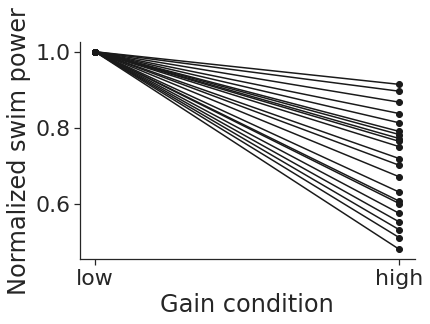

In [5]:
# swim behavioral statistics

mean_data = pd.DataFrame(fish_behavior.groupby(['fish_id','task_type'])['swim_length', 'swim_power'].mean()).reset_index()
low_gain = mean_data[mean_data['task_type']==1]['swim_power'].values
high_gain = mean_data[mean_data['task_type']==2]['swim_power'].values

plt.plot(['low', 'high'],[low_gain/low_gain, high_gain/low_gain], '-ok')
plt.xlabel('Gain condition')
plt.ylabel('Normalized swim power')
sns.despine()
plt.show()

## Gain adaption + ablation

In [6]:
gain_stat_len = 100
sig_thres = 0.0

In [7]:
vol_file = '../Analysis/depreciated/analysis_sections_ablation_gain.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

swim_len_list = []
swim_type_list = []
swim_power_list = []
fish_id = []
swim_sig = []
ablt_id = []

for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    task_period = _['task_period'].astype('int')
    if not 'control' in task_type:
        continue
    visu = _['visu']
    p_swim = r_swim + l_swim
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    swim_len = swim_ends - swim_starts
    
    gain_stat = np.zeros(gain_stat_len)
    gain_sig_stat = np.ones(gain_stat_len)
    if (task_period==2).sum()>0:
        for ntime in range(gain_stat_len):
            val, pval= ranksums(p_swim[task_period==1, t_pre+ntime], p_swim[task_period==2, t_pre+ntime])
            gain_stat[ntime] = np.sign(val) * pval
            gain_sig_stat[ntime] = (val>0) and (pval<0.05)
    print(folder+fish)
    if 'before' in task_type:
        tt = 'before'
    if 'after' in task_type:
        tt = 'after'
        
    swim_power = np.zeros(len(swim_len))
    swim_power[:] = np.nan
    for n_swim in range(len(swim_len)):
        if swim_len[n_swim]>0:
            swim_power[n_swim] = p_swim[n_swim, t_pre:(t_pre+swim_len[n_swim])].mean()

    if (tt=='before') and (gain_sig_stat.mean()<sig_thres):
        continue  
    
    if (tt=='after') and (not (folder[:4]+'_'+fish[:5]) in fish_id):
        continue
    
    swim_type_list.extend(task_period)
    swim_sig.extend([gain_sig_stat.mean()]*len(swim_len))
    fish_id.extend([folder[:4]+'_'+fish[:5]]*len(swim_len))
    ablt_id.extend([tt]*len(swim_len))
    # fish_id.extend([folder+'_'+fish]*len(swim_len))
    swim_len_list.extend(swim_len)
    swim_power_list.extend(swim_power)

fish_behavior = [('fish_id', fish_id), ('ablt_id', ablt_id), ('task_type', swim_type_list), ('swim_length', swim_len_list), ('swim_power', swim_power_list), ('swim_sig', swim_sig)]
fish_behavior = pd.DataFrame.from_items(fish_behavior)

08112019Fish3-1-before
08112019Fish3-2-before
08112019Fish3-1-after
08112019Fish3-2-after
08112019Fish4-1-before
08112019Fish4-2-before
08112019Fish4-1-after
08112019Fish4-2-after
08112019Fish6-1-before
08112019Fish6-1-after
08122019Fish1-1-before
08122019Fish1-2-before
08122019Fish1-1-after
08122019Fish1-2-after
08122019Fish2-1-before
08122019Fish2-2-before
08122019Fish2-1-after
08122019Fish2-2-after
08122019Fish3-1-before
08122019Fish3-2-before
08122019Fish3-1-after
08122019Fish3-2-after
08122019Fish4-1-before
08122019Fish4-2-before
08122019Fish4-1-after
08122019Fish4-2-after
08122019Fish6-1-before
08122019Fish6-2-before
08122019Fish6-2-after


/groups/ahrens/home/weiz/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


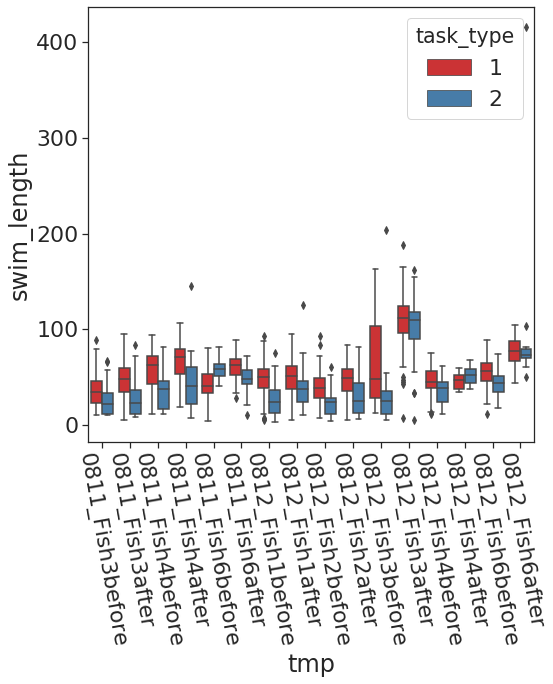

In [8]:
plt.figure(figsize=(8, 8))
fish_behavior['tmp'] = fish_behavior['fish_id'] + fish_behavior['ablt_id']
sns.boxplot(x="tmp", y="swim_length", hue="task_type", data=fish_behavior, palette="Set1")
plt.xticks(rotation=-80)
plt.show()

In [9]:
vol_file = '../Analysis/depreciated/analysis_sections_ablation_gain.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
valid_fish = np.unique(fish_id).tolist()
valid_list = []
for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    if (folder[:4]+'_'+fish[:5]) in valid_fish:
        valid_list.append(True)
    else:
        valid_list.append(False)
dat_xls_file[valid_list].to_csv('../Analysis/depreciated/analysis_sections_ablation_gain_update.csv')            

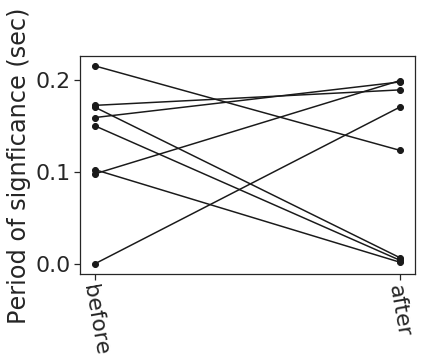

In [10]:
mean_data = pd.DataFrame(fish_behavior.groupby(['fish_id', 'ablt_id'])['swim_sig', 'swim_power', 'swim_length'].mean()).reset_index()
valid_list = np.ones(len(mean_data)).astype('bool')
for _, n_fish in mean_data.iterrows():
    if sum(mean_data['fish_id']==n_fish['fish_id']) !=2:
        valid_list[_] = False
mean_data = mean_data[valid_list]
before_ = mean_data[mean_data['ablt_id']=='before']['swim_sig'].values*gain_stat_len/300
after_ = mean_data[mean_data['ablt_id']=='after']['swim_sig'].values*gain_stat_len/300
plt.plot(['before', 'after'], [before_, after_], '-ok')
plt.xticks(rotation=-80)
plt.ylabel('Period of signficance (sec)')
plt.show()

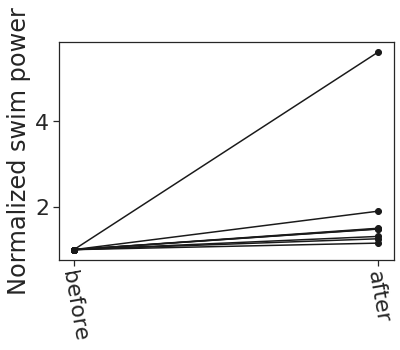

In [11]:
before_ = mean_data[mean_data['ablt_id']=='before']['swim_power'].values
after_ = mean_data[mean_data['ablt_id']=='after']['swim_power'].values
plt.plot(['before', 'after'], [before_/before_, after_/before_], '-ok')
plt.xticks(rotation=-80)
plt.ylabel('Normalized swim power')
plt.show()

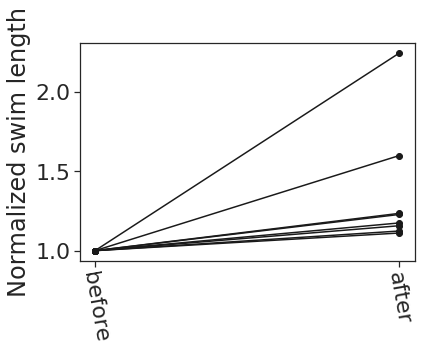

In [12]:
before_ = mean_data[mean_data['ablt_id']=='before']['swim_length'].values
after_ = mean_data[mean_data['ablt_id']=='after']['swim_length'].values
plt.plot(['before', 'after'], [before_/before_, after_/before_], '-ok')
plt.xticks(rotation=-80)
plt.ylabel('Normalized swim length')
plt.show()

## Swim-only visual-only task

In [15]:
fish_behavior = fish_behavior[fish_behavior['task_type']>0]

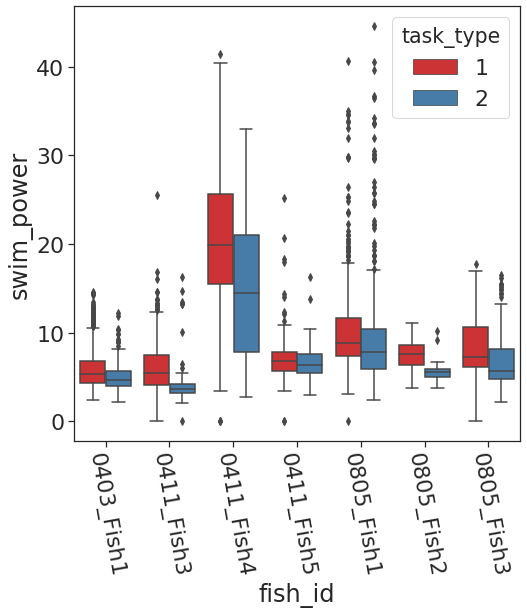

In [16]:
plt.figure(figsize=(8, 8))
sns.boxplot(x="fish_id", y="swim_power", hue="task_type", data=fish_behavior, palette="Set1")
plt.xticks(rotation=-80)
plt.show()

## Swim-only visual-only ablation

In [17]:
vol_file = '../Analysis/depreciated/analysis_sections_ablation_sovo.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

swim_len_list = []
swim_type_list = []
swim_power_list = []
fish_id = []
swim_sig = []
ablt_id = []

for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    task_period = _['swim_task_index'].astype('int')
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2 + l_swim**2)
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    swim_len = swim_ends - swim_starts
    
#     gain_stat = np.zeros(gain_stat_len)
#     gain_sig_stat = np.ones(gain_stat_len)
#     if (task_period==2).sum()>0:
#         for ntime in range(gain_stat_len):
#             val, pval= ranksums(p_swim[task_period==1, t_pre+ntime], p_swim[task_period==2, t_pre+ntime])
#             gain_stat[ntime] = np.sign(val) * pval
#             gain_sig_stat[ntime] = (val>0) and (pval<0.05)
    
    if 'before' in task_type:
        tt = 'before'
    if 'after' in task_type:
        tt = 'after'
        
    swim_power = np.zeros(len(swim_len))
    swim_power[:] = np.nan
    for n_swim in range(len(swim_len)):
        if swim_len[n_swim]>10:
            swim_power[n_swim] = p_swim[n_swim, t_pre:(t_pre+swim_len[n_swim])].mean()

#     if (tt=='before') and (gain_sig_stat.mean()<sig_thres):
#         continue  
    
#     if (tt=='after') and (not (folder[:4]+'_'+fish[:5]) in fish_id):
#         continue
    
    swim_type_list.extend(task_period)
    swim_sig.extend([gain_sig_stat.mean()]*len(swim_len))
    fish_id.extend([folder[:4]+'_'+fish[:5]]*len(swim_len))
    ablt_id.extend([tt]*len(swim_len))
    # fish_id.extend([folder+'_'+fish]*len(swim_len))
    swim_len_list.extend(swim_len)
    swim_power_list.extend(swim_power)

fish_behavior = [('fish_id', fish_id), ('ablt_id', ablt_id), ('task_type', swim_type_list), ('swim_length', swim_len_list), ('swim_power', swim_power_list)]
fish_behavior = pd.DataFrame.from_items(fish_behavior)

/groups/ahrens/home/weiz/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:60: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


In [18]:
fish_behavior = fish_behavior[fish_behavior['task_type']>0]

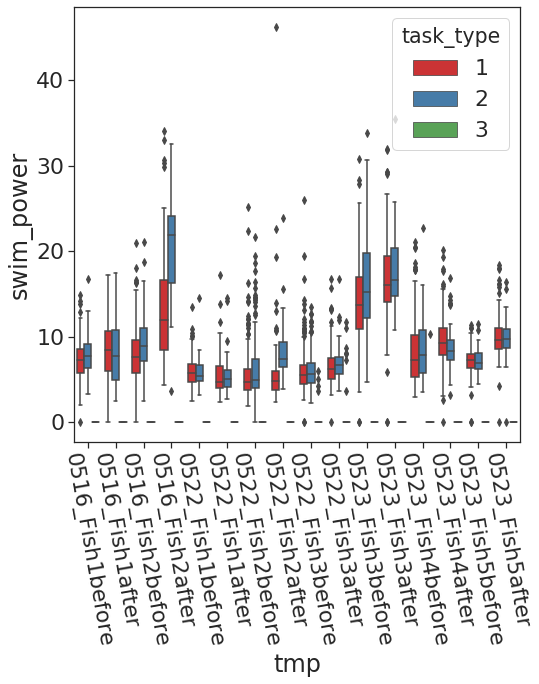

In [19]:
plt.figure(figsize=(8, 8))
fish_behavior['tmp'] = fish_behavior['fish_id'] + fish_behavior['ablt_id']
sns.boxplot(x="tmp", y="swim_power", hue="task_type", data=fish_behavior, palette="Set1")
plt.xticks(rotation=-80)
plt.show()

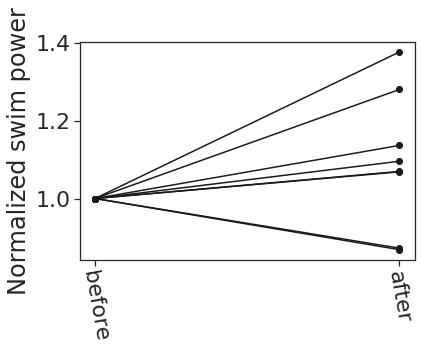

In [20]:
mean_data = pd.DataFrame(fish_behavior.groupby(['fish_id', 'ablt_id'])['swim_power', 'swim_length'].mean()).reset_index()
before_ = mean_data[mean_data['ablt_id']=='before']['swim_power'].values
after_ = mean_data[mean_data['ablt_id']=='after']['swim_power'].values
plt.plot(['before', 'after'], [before_/before_, after_/before_], '-ok')
plt.xticks(rotation=-80)
plt.ylabel('Normalized swim power')
plt.show()

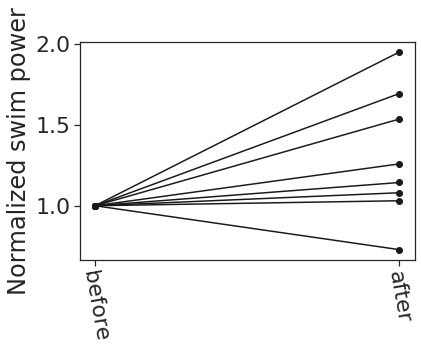

In [21]:
before_ = mean_data[mean_data['ablt_id']=='before']['swim_length'].values
after_ = mean_data[mean_data['ablt_id']=='after']['swim_length'].values
plt.plot(['before', 'after'], [before_/before_, after_/before_], '-ok')
plt.xticks(rotation=-80)
plt.ylabel('Normalized swim power')
plt.show()